In [1]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

from qiskit import QuantumCircuit, transpile
from qiskit.circuit.library import PauliEvolutionGate
from qiskit.quantum_info import SparsePauliOp, state_fidelity, Statevector
from qiskit_aer import StatevectorSimulator

delta_t = 0.2
p = 20

N = 4
state = QuantumCircuit(N)
state.initialize(Statevector.from_label("+"*N))

A = 4
B = 1

W = [0.1, 0.2, 0.3, 0.4]

HA = SparsePauliOp.from_sparse_list([("ZZ", [0, 1], +A/2), 
                                     ("ZZ", [2, 3], +A/2),
                                     ("ZZ", [0, 2], -A/2),
                                     ("ZZ", [1, 3], -A/2)],
                                    num_qubits=N)

HB_opl = [("Z", [i], B*W[i]/2) for i in range(N)]
HB = SparsePauliOp.from_sparse_list(HB_opl, num_qubits=N)

Hc = HA + HB

Hm_opl = [("X", [i], -1) for i in range(N)]
Hm = SparsePauliOp.from_sparse_list(Hm_opl, num_qubits=N)

for i in range(p+1):
    beta_i = (1 - i/p) * delta_t
    gamma_i = i/p * delta_t
    evolv_Hm = PauliEvolutionGate(Hm, time=beta_i)
    evolv_Hc = PauliEvolutionGate(Hc, time=gamma_i)
    state.append(evolv_Hm, state.qubits)
    state.append(evolv_Hc, state.qubits)
    state.save_statevector(label=f"{i}")

simulator = StatevectorSimulator()
%time circ = transpile(state, simulator)

%time result = simulator.run(circ).result()

CPU times: user 460 ms, sys: 350 ms, total: 810 ms
Wall time: 92 ms
CPU times: user 27.1 ms, sys: 37.1 ms, total: 64.2 ms
Wall time: 8.59 ms


In [2]:
# %%time
from qiskit_aer.primitives import Estimator

estimator = Estimator(approximation=True, 
                      backend_options={"method":"statevector"},
                      skip_transpilation=True)


circuits, observables = [], []
for i in range(p+1):
    state = QuantumCircuit(N)
    state.set_statevector(result.data()[f"{i}"])
    circuits.append(state)
    observables.append((1-i/p)*Hm + i/p*Hc)

%time E = estimator.run(circuits, observables).result().values

CPU times: user 16.3 ms, sys: 46.2 ms, total: 62.5 ms
Wall time: 7.36 ms


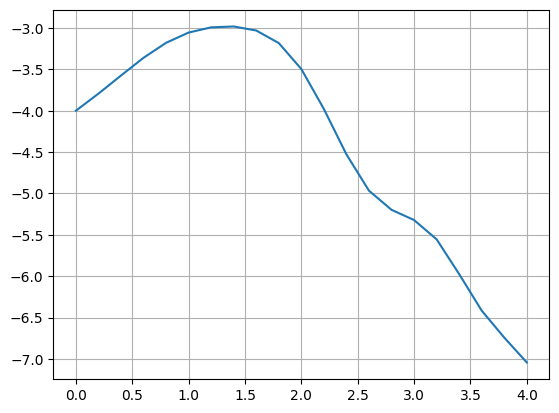

In [3]:
plt.plot(delta_t*np.arange(p+1), E)
plt.grid()

In [4]:
f_state = Statevector.from_label("1010")
f_circ = QuantumCircuit(N)
f_circ.set_statevector(f_state)

state_fidelity(result.data()[f"{p}"], f_state), 1 - E[-1] / estimator.run(f_circ, Hc).result().values[0]

(0.44235894922918206, 0.1304582133737956)

In [5]:
N = 7
M = 50

A = N
B = 1

# HA = SparsePauliOp.from_sparse_list([("ZZ", [0, 1], +A/2), 
#                                      ("ZZ", [2, 3], +A/2),
#                                      ("ZZ", [0, 2], -A/2),
#                                      ("ZZ", [1, 3], -A/2)],
#                                     num_qubits=N)

HA = SparsePauliOp.from_sparse_list([("ZZ", [0, 1], +A/2), 
                                     ("ZZ", [5, 6], +A/2),
                                     ("ZZ", [0, 2], -A/2),
                                     ("ZZ", [1, 3], -A/2),
                                     ("ZZ", [1, 4], -A/2),
                                     ("Z",  [1], -A/2),
                                     ("ZZ", [2, 3], +A/2),
                                     ("ZZ", [2, 5], -A/2),
                                     ("Z",  [2], +A/2),
                                     ("ZZ", [3, 4], +A/2),
                                     ("ZZ", [3, 5], -A/2),
                                     ("Z",  [3], +A),
                                     ("ZZ", [4, 6], -A/2),
                                     ("Z",  [4], +A/2),
                                     ("Z",  [5], -A/2)],
                                    num_qubits=N)

Hm_opl = [("X", [i], -1) for i in range(N)]
Hm = SparsePauliOp.from_sparse_list(Hm_opl, num_qubits=N)

simulator = StatevectorSimulator()

delta_t = np.arange(1, 22) * 0.01 + 0.24
max_fed_app = np.zeros((4, 4))
for l, p in enumerate([20, 30, 40, 100]):
    overlap = np.zeros((delta_t.shape[0], 2))
    approx_ratio = np.zeros((delta_t.shape[0], 2))
    for k, dt in enumerate(tqdm(delta_t)):
        overlap_M = np.zeros(M)
        approx_ratio_M = np.zeros(M)
        for j in range(M):
            W = np.random.random(N)
            HB_opl = [("Z", [i], B*W[i]/2) for i in range(N)]
            HB = SparsePauliOp.from_sparse_list(HB_opl, num_qubits=N)
    
            Hc = HA + HB
    
            state = QuantumCircuit(N)
            state.initialize(Statevector.from_label("+"*N))
    
            for i in range(p+1):
                beta_i = (1 - i/p) * dt
                gamma_i = i/p * dt
                evolv_Hm = PauliEvolutionGate(Hm, time=beta_i)
                evolv_Hc = PauliEvolutionGate(Hc, time=gamma_i)
                state.append(evolv_Hm, state.qubits)
                state.append(evolv_Hc, state.qubits)
            
            circ = transpile(state, simulator)
            result = simulator.run(circ).result()
    
            if ((W[0] + W[2] + W[5]) < (W[1] + W[3] + W[5])) and ((W[0] + W[2] + W[5]) < (W[1] + W[4] + W[6])):
                f_state = Statevector.from_label("1011010")
            elif ((W[1] + W[3] + W[5]) < (W[0] + W[2] + W[5])) and ((W[1] + W[3] + W[5]) < (W[1] + W[4] + W[6])):
                f_state = Statevector.from_label("1010101")
            else:
                f_state = Statevector.from_label("0101101")

            f_circ = QuantumCircuit(N)
            f_circ.set_statevector(f_state)

            approx_circ = QuantumCircuit(N)
            approx_circ.set_statevector(result.data()["statevector"])
    
            overlap_M[j] = state_fidelity(result.data()["statevector"], f_state)
            approx_ratio_M[j] = estimator.run(approx_circ, Hc).result().values[0] / estimator.run(f_circ, Hc).result().values[0]
        overlap[k] = np.mean(overlap_M), np.std(overlap_M) / np.sqrt(M)
        approx_ratio[k] = np.mean(approx_ratio_M), np.std(approx_ratio_M) / np.sqrt(M)
    max_fed_app[l] = (np.max(overlap[:, 0]), np.max(approx_ratio[:, 0]), \
                      delta_t[np.argmax(overlap[:, 0])], delta_t[np.argmax(approx_ratio[:, 0])])

100%|███████████████████████████████████████████| 21/21 [16:44<00:00, 47.85s/it]


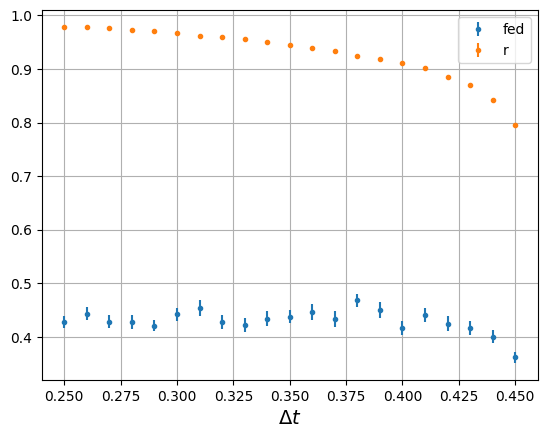

In [6]:
plt.errorbar(delta_t, overlap[:, 0], yerr=overlap[:, 1], fmt=".", label="fed")
plt.errorbar(delta_t, approx_ratio[:, 0], yerr=approx_ratio[:, 1], fmt=".", label="r")
plt.xlabel("$\Delta t$", fontsize=14)
plt.legend()
plt.grid()

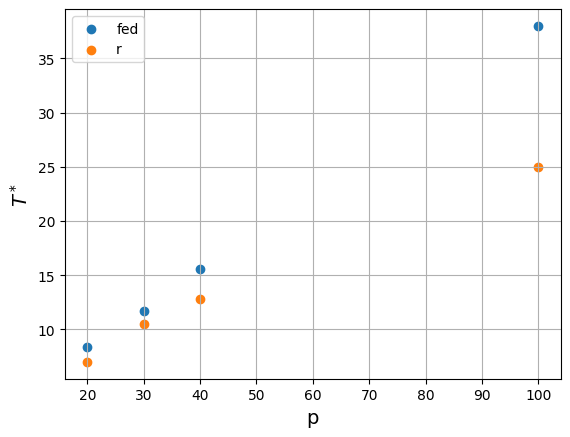

In [7]:
plt.scatter([20, 30, 40, 100],  np.array([20, 30, 40, 100])*max_fed_app[:, 2], label="fed")
plt.scatter([20, 30, 40, 100],  np.array([20, 30, 40, 100])*max_fed_app[:, 3], label="r")
plt.ylabel("$T^*$", fontsize=14)
plt.xlabel("p", fontsize=14, rotation="horizontal")
plt.legend()
plt.grid()